# Цели работы :

1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом Apache Spark и возможностями, которые он предоставляет для обработки больших данных;
3. Получить навыки выполнения разведочного анализа данных использованием pyspark

# Задачи работы

**Выполнить разведочный анализ датасета с определением:**

1. типов признаков в датасете;
2. пропущенных значений и их устранением;
3. выбросов и их устранением;
4. расчетом статистических показателей признаков (средних, квартилей и т.д.);
5. визуализацией распределения наиболее важных признаков;
6. корреляций между признаками

Датасет авиабилетов из "Expedia": https://www.kaggle.com/datasets/dilwong/flightprices

In [2]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
import pylab 
import seaborn as sns
import scipy.stats as scipy_stats
from scipy.stats import probplot
from functools import reduce

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [3]:
!pip install pyspark
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row, DataFrame, SparkSession, SQLContext, functions, Window
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import skewness, lit, desc, col,when, size, array_contains, row_number, \
isnan, udf, hour, array_min, array_max, countDistinct, median, collect_list, \
max, mean, min, stddev, monotonically_increasing_id  
from pyspark.sql.types import *

In [4]:
MAX_MEMORY = '15G'

# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Tp_Lab1") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'itineraries.csv'

# Load the main data set into pyspark data frame 
df = spark.read.options(inferSchema='True', header='True', delimeter=',').csv(filename_data, mode='DROPMALFORMED')
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [5]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

In [4]:
df.limit(10).toPandas()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach
2,98d90cbc32bfbb05c2fc32897c7c1087,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650218700,2022-04-17T14:05:00.000-04:00,BOS,ATL,Delta,DL,Boeing 757-200,9000,947,coach
3,969a269d38eae583f455486fa90877b4,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H32M,0,False,False,...,1650227460,2022-04-17T16:31:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9120,947,coach
4,980370cf27c89b40d2833a1d5afc9751,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H34M,0,False,False,...,1650213180,2022-04-17T12:33:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9240,947,coach
5,79eda9f841e226a1e2121d74211e595c,2022-04-16,2022-04-17,ATL,BOS,VH0AUEL1,PT2H38M,0,False,False,...,1650216180,2022-04-17T13:23:00.000-04:00,BOS,ATL,JetBlue Airways,B6,None,9480,947,coach
6,9335fae376c38bb61263281779f469ec,2022-04-16,2022-04-17,ATL,BOS,V0AJZNN1,PT4H12M,0,False,False,...,1650203400||1650213120,2022-04-17T09:50:00.000-04:00||2022-04-17T12:3...,CLT||BOS,ATL||CLT,American Airlines||American Airlines,AA||AA,Airbus A320||Airbus A320,5400||7500,228||728,coach||coach
7,3904bf87f2d1daf334f1ae7e3b876028,2022-04-16,2022-04-17,ATL,BOS,V0AJZNN1,PT5H18M,0,False,False,...,1650203400||1650217080,2022-04-17T09:50:00.000-04:00||2022-04-17T13:3...,CLT||BOS,ATL||CLT,American Airlines||American Airlines,AA||AA,Airbus A320||Boeing 737-800,5400||8280,228||728,coach||coach
8,d93988734c44a3c075d9efe373352507,2022-04-16,2022-04-17,ATL,BOS,V0AJZNN1,PT5H32M,0,False,False,...,1650198060||1650213120,2022-04-17T08:21:00.000-04:00||2022-04-17T12:3...,CLT||BOS,ATL||CLT,American Airlines||American Airlines,AA||AA,Airbus A319||Airbus A320,4860||7500,228||728,coach||coach
9,562e7d5dd6ecbf1509c0c19711dbdca9,2022-04-16,2022-04-17,ATL,BOS,V0AJZNN1,PT6H38M,0,False,False,...,1650198060||1650217080,2022-04-17T08:21:00.000-04:00||2022-04-17T13:3...,CLT||BOS,ATL||CLT,American Airlines||American Airlines,AA||AA,Airbus A319||Boeing 737-800,4860||8280,228||728,coach||coach


In [9]:
df.select("legId").show(10)

+--------------------+
|               legId|
+--------------------+
|9ca0e81111c683bec...|
|98685953630e772a0...|
|98d90cbc32bfbb05c...|
|969a269d38eae583f...|
|980370cf27c89b40d...|
|79eda9f841e226a1e...|
|9335fae376c38bb61...|
|3904bf87f2d1daf33...|
|d93988734c44a3c07...|
|562e7d5dd6ecbf150...|
+--------------------+
only showing top 10 rows



## 1. Типы признаков в датасете

In [17]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDeparture

,Column Name,Data type
0,legId,string
1,searchDate,date
2,flightDate,date
3,startingAirport,string
4,destinationAirport,string
5,fareBasisCode,string
6,travelDuration,string
7,elapsedDays,int
8,isBasicEconomy,boolean
9,isRefundable,boolean


In [54]:
print('Data frame describe (string and numeric columns only):')
print(f'Total rows: {df.count()}')
df.describe().toPandas()

Data frame describe (string and numeric columns only):
Total rows: 1047402


,summary,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,baseFare,totalFare,seatsRemaining,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,count,1047402,1047402,1047402,1047402,1047402,1047402,1047402,1047402,1047402,...,1047402,1047402,1047402,1047402,1047402,1047402,1027732,1047402,1047402,1047402
1,mean,None,None,None,None,None,0.14670393984353666,301.27889388219666,349.46088737638536,5.656337299336835,...,1.652550230958727E9,None,None,None,None,None,None,10976.953229218601,1088.8510624296475,None
2,stddev,None,None,None,None,None,0.35381609964964894,219.55818368969457,235.70129412439218,2.9535581400822295,...,1438511.181605473,None,None,None,None,None,None,5163.055574124524,722.9223031101131,None
3,min,00000115f8d6a14453bcd1bbc90fbd0b,ATL,ATL,A0ATZNFC,P1DT12M,0,5.1,23.97,0,...,1650186900,2022-04-17T04:29:00.000-06:00,ABE||ATL,ATL,Alaska Airlines,4B||4B||AA,AIRBUS INDUSTRIE A320 SHARKLETS,10020,1007||207,business
4,max,ffffca93f7396a1e6bfac059ffa5abf5,SFO,SFO,ZVAZZNN3,PT9H9M,2,3531.16,3810.6,10,...,1655469420||1655492220,2022-06-17T08:37:00.000-04:00||2022-06-17T14:5...,XNA||ORD,TTN||RDU,United||United||United||United,UA||UA||UA||UA,||||Embraer 175 (Enhanced Winglets),9960||9960,None||None||None,premium coach||premium coach||coach


## 2. Обнаружение пропущенных значений и аномальных нулей

In [20]:
string_columns = [
    'legId', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration', 
    'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 
    'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 
    'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 
    'segmentsDistance', 'segmentsCabinCode'
]

numeric_with_zeroes_columns = ['elapsedDays', 'seatsRemaining']
numeric_without_zeroes_columns = ['baseFare', 'totalFare', 'totalTravelDistance']

boolean_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop']

date_columns = ['searchDate', 'flightDate']

missing_values = {} 

for index, column in enumerate(df.columns):
    if column in string_columns: # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_with_zeroes_columns: # check None, NaN and Null
        missing_count = df.filter(col(column) == None | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_without_zeroes_columns:  # check zeroes, None, NaN and Null
        missing_count = df.filter(col(column).isin([0,None]) | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in boolean_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in date_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

columns_with_missing_values = []
for column in missing_df:
    if missing_df[column].values[0] != 0:
        columns_with_missing_values.append(column)

missing_df[columns_with_missing_values]
print(missing_values)

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,19670,0,0,0


,totalTravelDistance,segmentsEquipmentDescription
0,64719,19670


{'legId': 0, 'searchDate': 0, 'flightDate': 0, 'startingAirport': 0, 'destinationAirport': 0, 'fareBasisCode': 0, 'travelDuration': 0, 'elapsedDays': 0, 'isBasicEconomy': 0, 'isRefundable': 0, 'isNonStop': 0, 'baseFare': 0, 'totalFare': 0, 'seatsRemaining': 0, 'totalTravelDistance': 64719, 'segmentsDepartureTimeEpochSeconds': 0, 'segmentsDepartureTimeRaw': 0, 'segmentsArrivalTimeEpochSeconds': 0, 'segmentsArrivalTimeRaw': 0, 'segmentsArrivalAirportCode': 0, 'segmentsDepartureAirportCode': 0, 'segmentsAirlineName': 0, 'segmentsAirlineCode': 0, 'segmentsEquipmentDescription': 19670, 'segmentsDurationInSeconds': 0, 'segmentsDistance': 0, 'segmentsCabinCode': 0}


In [21]:
mean_value = df.agg(mean(df['totalTravelDistance'])).collect()[0][0]
mean_value

1578.2174546623885

In [23]:
df_fill = df.withColumn('totalTravelDistanceWasNull', when(df['totalTravelDistance'].isNull(), 1).otherwise(0))
df_fill=df_fill.na.fill(value=mean_value,subset=["totalTravelDistance"])
df_fill.select('totalTravelDistance','totalTravelDistanceWasNull').limit(100).toPandas()

,totalTravelDistance,totalTravelDistanceWasNull
0,947,0
1,947,0
2,947,0
3,947,0
4,947,0
...,...,...
95,1578,1
96,725,0
97,725,0
98,725,0


In [24]:
print(f'Number of rows before deleting na values: {df.count()}')
df = df.na.drop(subset=columns_with_missing_values)
print(f'Number of rows after deleting na values: {df.count()}')

Number of rows before deleting na values: 1047402
Number of rows after deleting na values: 965739


In [25]:
print(f'Number of rows before deleting na values: {df_fill.count()}')
df_fill = df_fill.na.drop(subset=columns_with_missing_values)
print(f'Number of rows after deleting na values: {df_fill.count()}')

Number of rows before deleting na values: 1047402
Number of rows after deleting na values: 1027732


## 3. Определение выбросов и удаление выбросов

In [6]:
df.count()

1047402

In [7]:
cleaned_dataframe = df.dropna()
cleaned_dataframe.count()

965739

In [8]:
from pyspark.sql import functions as F

selected_columns = ['baseFare', 'totalFare', 'totalTravelDistance']

# Фильтрация выбросов для каждого столбца
for column in selected_columns:
    # Рассчет квартилей
    quartiles = cleaned_dataframe.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    # Рассчет межквартильного размаха
    IQR = quartiles[1] - quartiles[0]

    # Определение границ для определения выбросов
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR

    # Фильтрация данных и подсчет значений ниже и выше усов
    below_quartile_count_before = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_before = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (до)'{column}': Снизу выбросов - {below_quartile_count_before}, Сверху выбросов - {above_quartile_count_before}")

    # Рассчет максимального и минимального значения до фильтрации
    max_value_before = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_before = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы до фильтрации
    median_value_before = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (до) '{column}': Максимальное значение - {max_value_before}, Минимальное значение - {min_value_before}, Медиана - {median_value_before}")

    # Фильтрация данных
    cleaned_dataframe = cleaned_dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    # Фильтрация данных и подсчет значений ниже и выше усов
    below_quartile_count_after = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_after = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (после)'{column}': Снизу выбросов - {below_quartile_count_after}, Сверху выбросов - {above_quartile_count_after}")

    # Рассчет максимального и минимального значения после фильтрации
    max_value_after = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_after = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы после фильтрации
    median_value_after = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (после) '{column}': Максимальное значение - {max_value_after}, Минимальное значение - {min_value_after}, Медиана - {median_value_after}")

Столбец (до)'baseFare': Снизу выбросов - 0, Сверху выбросов - 21031
Столбец (до) 'baseFare': Максимальное значение - 3531.16, Минимальное значение - 8.72, Медиана - 277.21
Столбец (после)'baseFare': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'baseFare': Максимальное значение - 753.79, Минимальное значение - 8.72, Медиана - 273.49
Столбец (до)'totalFare': Снизу выбросов - 0, Сверху выбросов - 1402
Столбец (до) 'totalFare': Максимальное значение - 847.8, Минимальное значение - 23.97, Медиана - 317.19
Столбец (после)'totalFare': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'totalFare': Максимальное значение - 819.3, Минимальное значение - 23.97, Медиана - 316.61
Столбец (до)'totalTravelDistance': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (до) 'totalTravelDistance': Максимальное значение - 3958, Минимальное значение - 97, Медиана - 1392.0
Столбец (после)'totalTravelDistance': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'totalTravelDistance': Максим

## 4. Расчет статистических показателей признаков

In [11]:
from pyspark.sql.functions import lit, desc, col, size, array_contains, isnan, udf, hour, array_min, array_max, countDistinct, expr

dataframe = df.select('startingAirport', 'destinationAirport', 'isNonStop',
                    'isBasicEconomy', 'isRefundable', 'baseFare', 'totalFare', 
                    'seatsRemaining', 'totalTravelDistance', 'travelDuration')
# Извлечение часов и минут из travelDuration
dataframe = dataframe.withColumn("hours", expr("CAST(SPLIT(SUBSTRING(travelDuration, 3), 'H')[0] AS INT)"))
dataframe = dataframe.withColumn("minutes", expr("CAST(SPLIT(SPLIT(SUBSTRING(travelDuration, 3), 'H')[1], 'M')[0] AS INT)"))

# Преобразование в минуты
dataframe = dataframe.withColumn("travelDuration", expr("hours * 60 + minutes"))
dataframe = dataframe.drop("hours", "minutes")

dataframe.limit(5).toPandas()

,startingAirport,destinationAirport,isNonStop,isBasicEconomy,isRefundable,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDuration
0,ATL,BOS,True,False,False,217.67,248.6,9,947,149
1,ATL,BOS,True,False,False,217.67,248.6,4,947,150
2,ATL,BOS,True,False,False,217.67,248.6,9,947,150
3,ATL,BOS,True,False,False,217.67,248.6,8,947,152
4,ATL,BOS,True,False,False,217.67,248.6,9,947,154


## 5. Визуализацией распределения наиболее важных признаков

In [63]:
def plot_histogram(df, column):

    data = df.select(collect_list(column)).first()[0]
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins='auto', color='blue')

    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    
    plt.show()

In [64]:
def plot_boxplot(df, column):
  
    data = df.select(collect_list(column)).first()[0]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, vert=False)  # vert=False для горизонтального ящика

    plt.title(f"Box plot of '{column}'")
    plt.xlabel(column)
    plt.show()

Column: elapsedDays


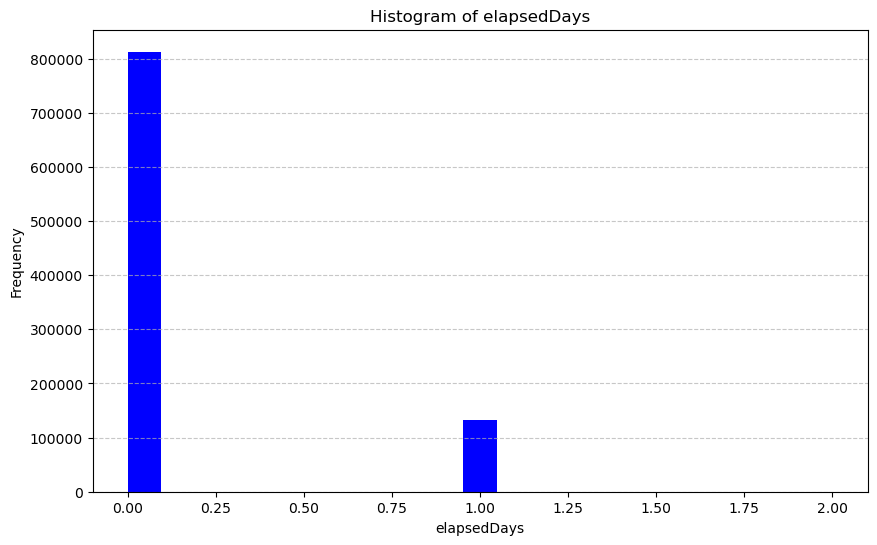

Column: seatsRemaining


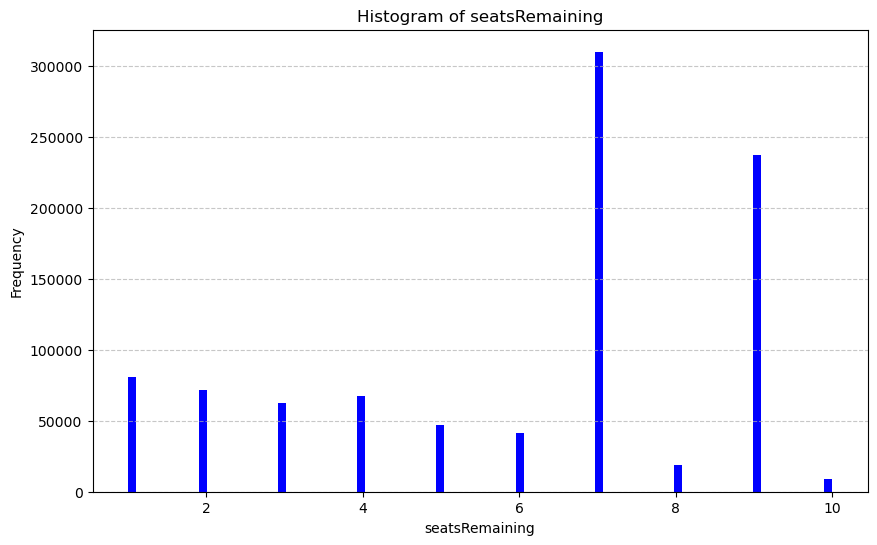

Column: baseFare


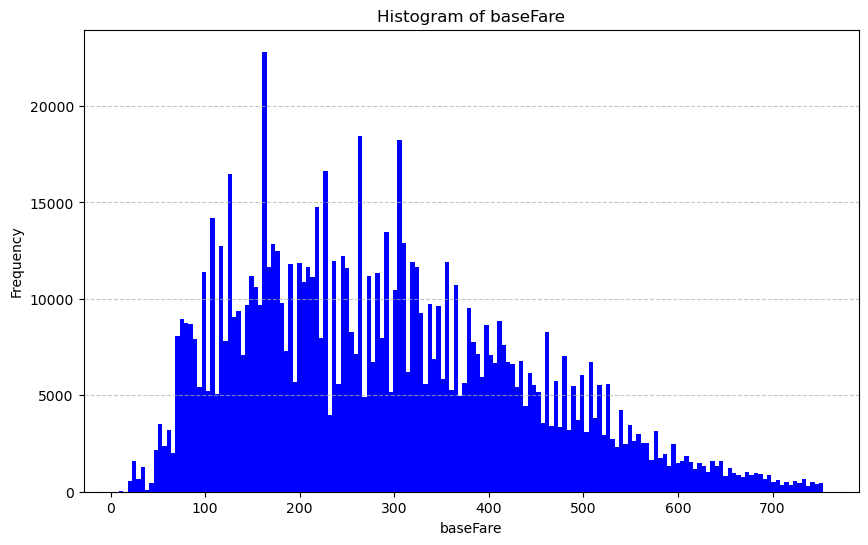

Column: totalFare


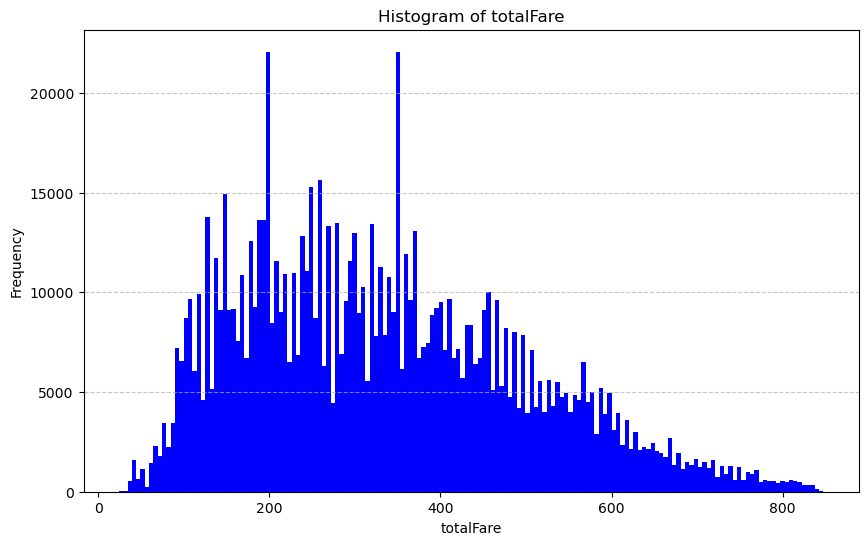

Column: totalTravelDistance


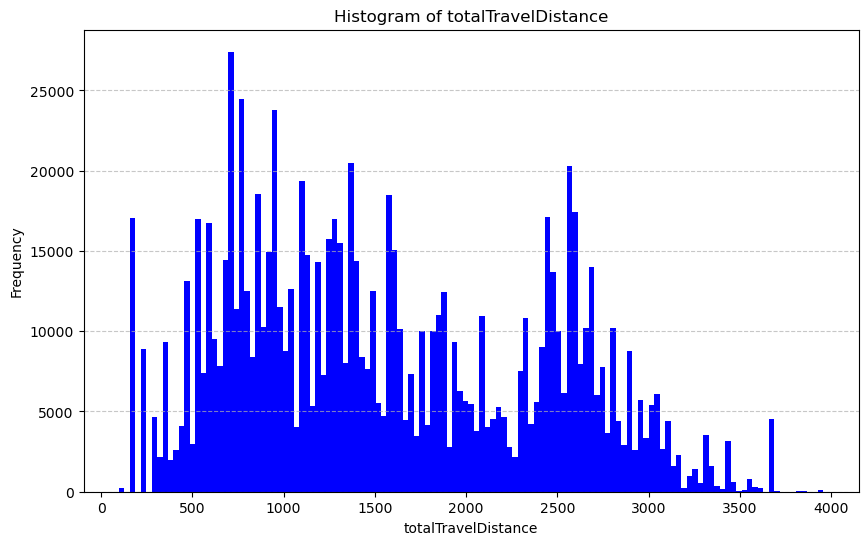

In [66]:
for column in numeric_with_zeroes_columns:
    print(f'Column: {column}')
    plot_histogram(cleaned_df, column)

for column in numeric_without_zeroes_columns:
    print(f'Column: {column}')
    plot_histogram(cleaned_df, column)

Column: elapsedDays


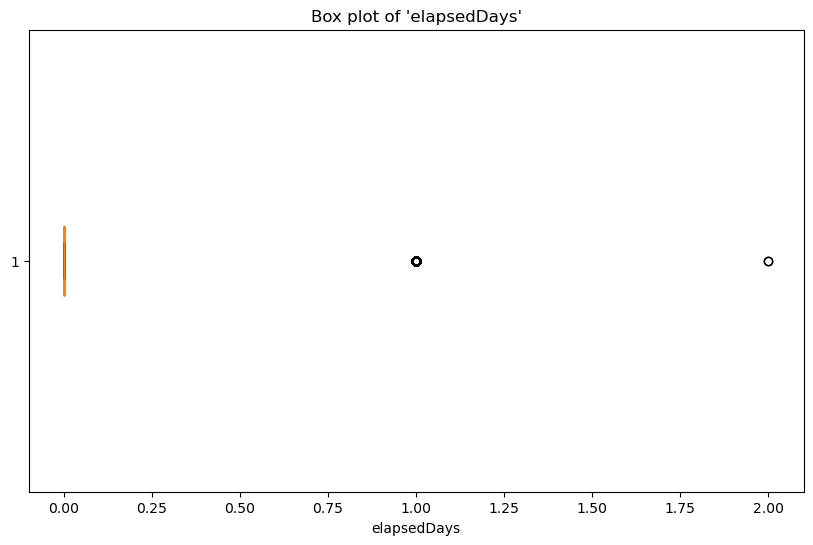

Column: seatsRemaining


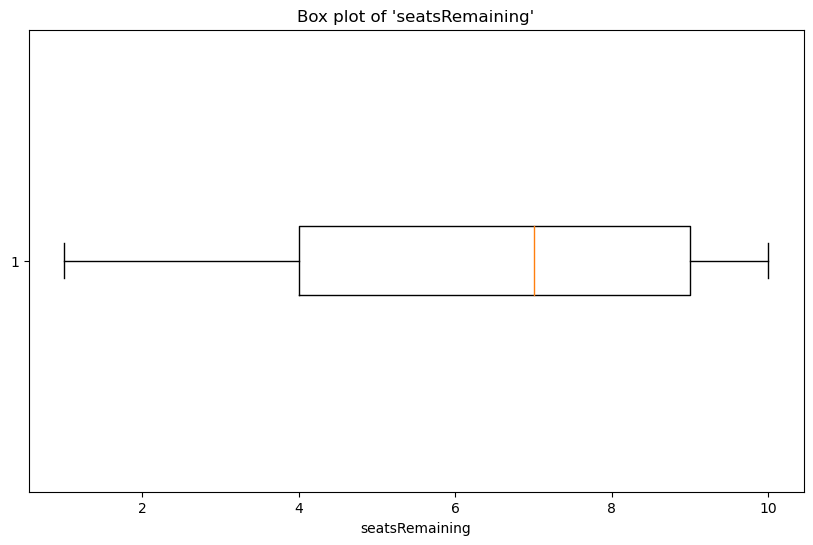

Column: baseFare


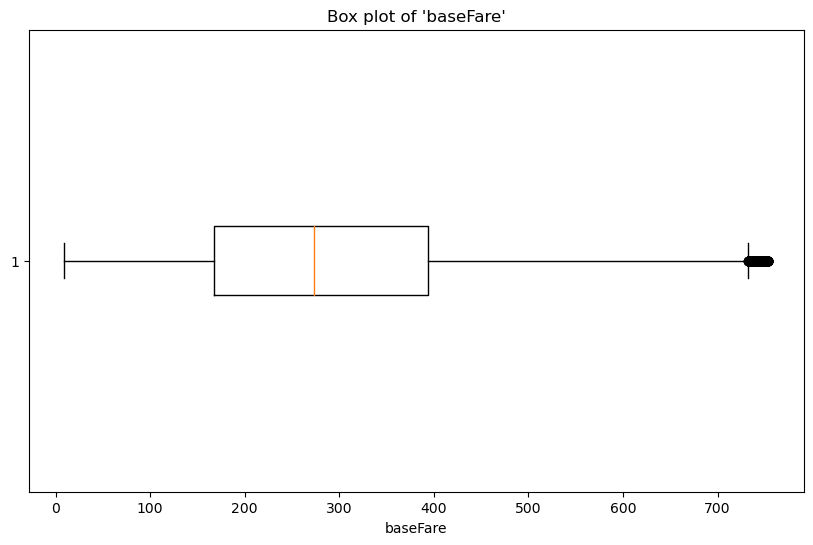

Column: totalFare


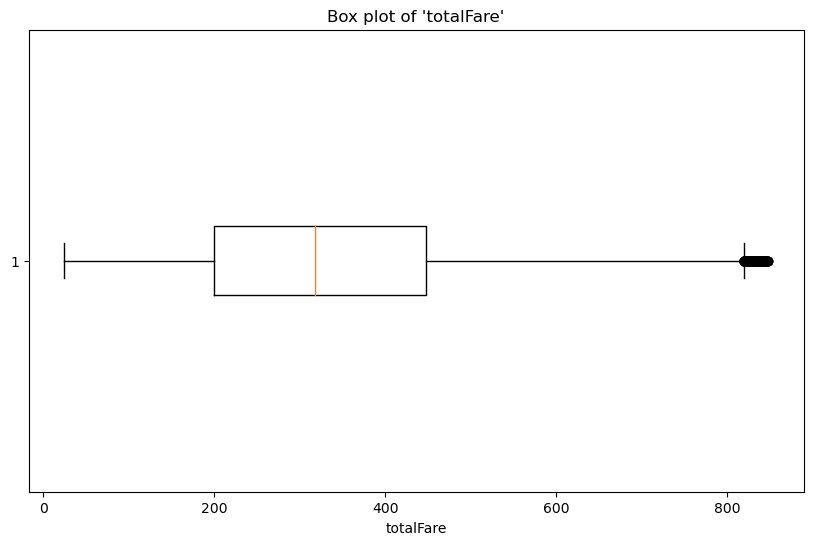

Column: totalTravelDistance


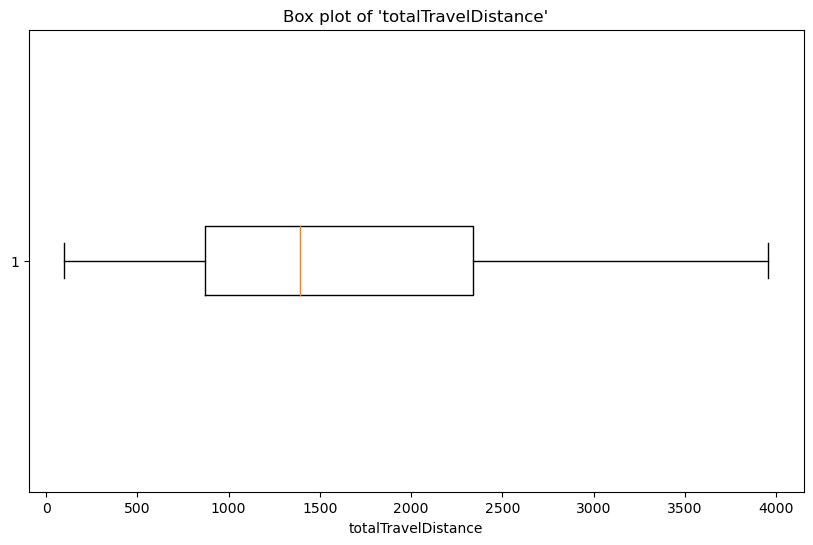

In [68]:
for column in numeric_with_zeroes_columns:
    print(f'Column: {column}')
    plot_boxplot(cleaned_df, column)

for column in numeric_without_zeroes_columns:
    print(f'Column: {column}')
    plot_boxplot(cleaned_df, column)

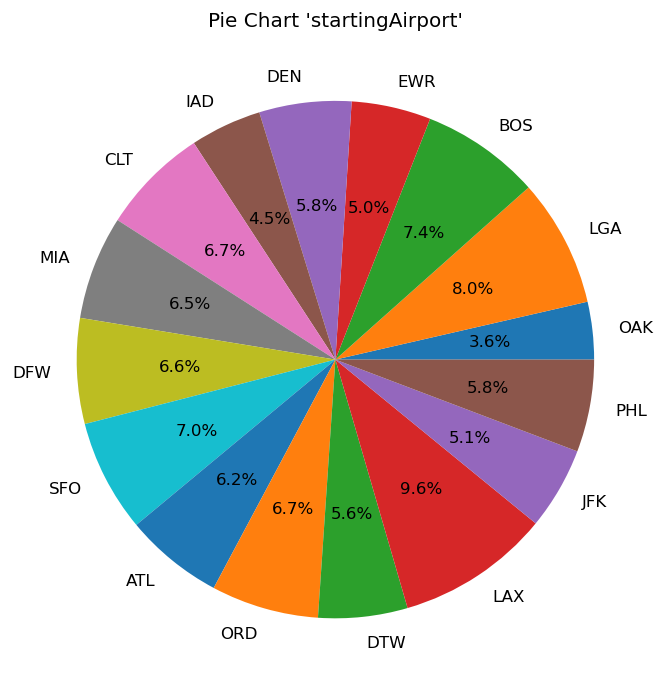

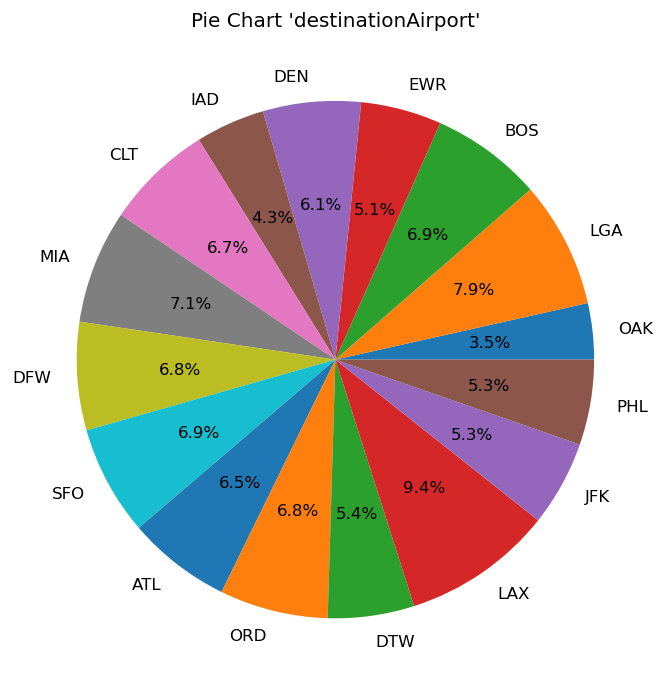

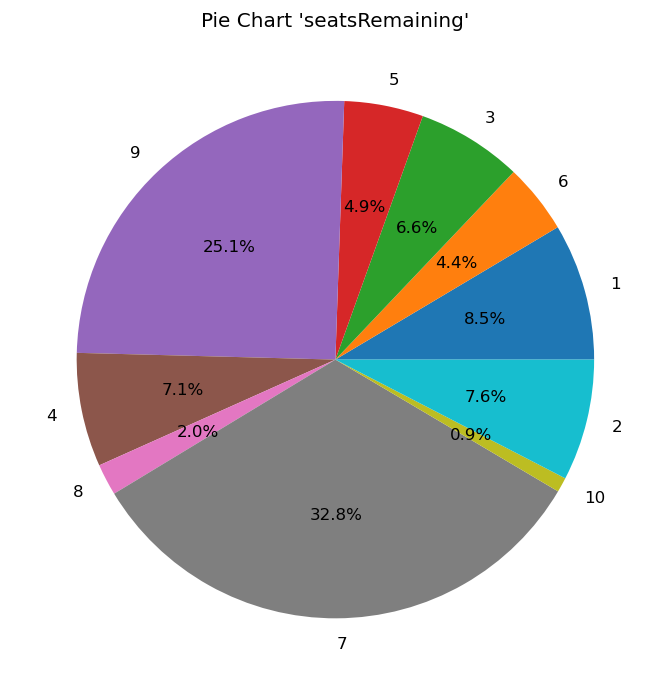

In [74]:
def pie_chart(df, column):
    
    pandas_df = df.groupby(column).count().toPandas()
    pandas_df = pandas_df.set_index(pandas_df.columns[0])
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect='equal'), dpi=120)

    data = pandas_df['count']
    categories = pandas_df.index

    plt.pie(data, labels = categories, autopct="%1.1f%%")
    ax.set_title(f"Pie Chart '{column}'")
    plt.show() 
    
pie_chart(cleaned_df, 'startingAirport')
pie_chart(cleaned_df, 'destinationAirport')
pie_chart(cleaned_df, 'seatsRemaining')


+-------------+------+
|bucketFeature| count|
+-------------+------+
|          1.0|307919|
|          2.0|412348|
|          3.0|193847|
|          4.0| 28219|
+-------------+------+



<BarContainer object of 4 artists>

Text(0.5, 1.0, 'Distribution of baseFare')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

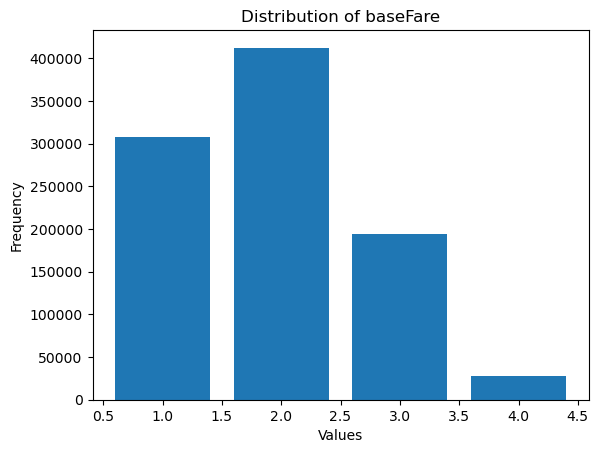

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          1.0|237504|
|          2.0|403257|
|          3.0|238090|
|          4.0| 62369|
|          5.0|  1113|
+-------------+------+



<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Distribution of totalFare')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

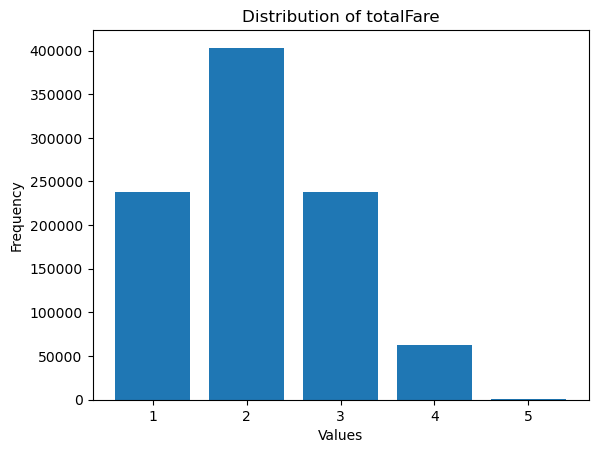

+-------------+------+
|bucketFeature| count|
+-------------+------+
|          1.0| 17315|
|          2.0| 27094|
|          3.0| 58595|
|          4.0|105550|
|          5.0| 97436|
|          6.0| 74841|
|          7.0| 99484|
|          8.0| 57751|
|          9.0| 52418|
|         10.0| 59341|
|         11.0| 35993|
|         12.0| 35678|
|         13.0| 84682|
|         14.0| 63933|
|         15.0| 31465|
|         16.0| 22302|
|         17.0|  8519|
|         18.0|  5233|
|         19.0|  4505|
|         20.0|   198|
+-------------+------+



<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of totalTravelDistance')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

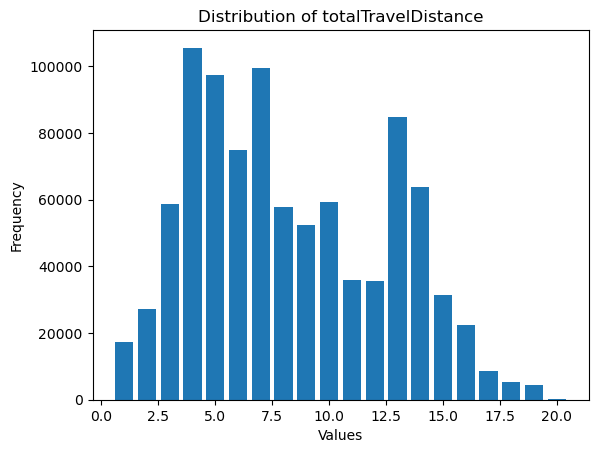

In [11]:
from pyspark.ml.feature import VectorAssembler,Bucketizer
num_buckets = 20
step = 4000 / num_buckets
splits = [float("-inf")] + [i * step for i in range(0, num_buckets)] + [float("inf")]
selected_columns = ['baseFare', 'totalFare','totalTravelDistance']

# Построение гистограммы для каждой колонки
for selected_column in selected_columns:
    bucketizer = Bucketizer(splits=splits, inputCol=selected_column, outputCol="bucketFeature")
    df_bucket = bucketizer.transform(cleaned_dataframe)
    bucket_counts = df_bucket.groupBy("bucketFeature").count().orderBy("bucketFeature")
    bucket_counts.show()
    bucket_counts_pd = bucket_counts.toPandas()
    plt.bar(bucket_counts_pd["bucketFeature"], bucket_counts_pd["count"], align="center", label=selected_column)
    plt.title(f"Distribution of {selected_column}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

<BarContainer object of 16 artists>

Text(0.5, 1.0, 'Distribution of startingAirport')

Text(0.5, 0, 'startingAirport')

Text(0, 0.5, 'Count')

<BarContainer object of 16 artists>

Text(0.5, 1.0, 'Distribution of destinationAirport')

Text(0.5, 0, 'destinationAirport')

Text(0, 0.5, 'Count')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Distribution of isNonStop')

Text(0.5, 0, 'isNonStop')

Text(0, 0.5, 'Count')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Distribution of isBasicEconomy')

Text(0.5, 0, 'isBasicEconomy')

Text(0, 0.5, 'Count')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Distribution of isRefundable')

Text(0.5, 0, 'isRefundable')

Text(0, 0.5, 'Count')

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Distribution of seatsRemaining')

Text(0.5, 0, 'seatsRemaining')

Text(0, 0.5, 'Count')

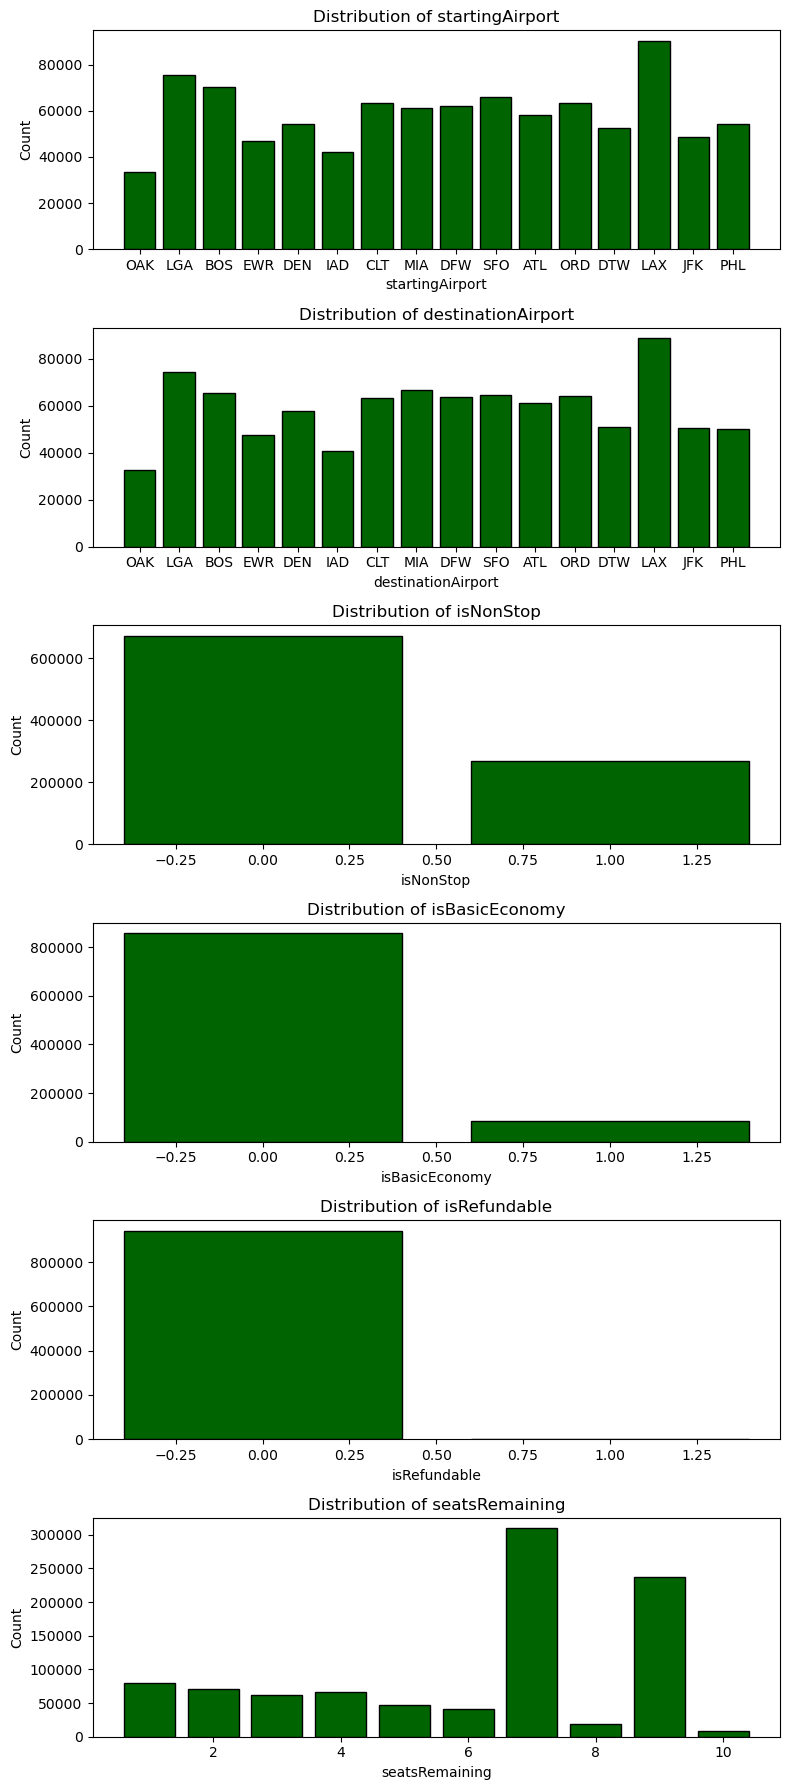

In [15]:
selected_features = ['startingAirport', 'destinationAirport', 'isNonStop',
                    'isBasicEconomy', 'isRefundable', 
                    'seatsRemaining'] 

fig, axs = plt.subplots(len(selected_features), 1, figsize=(8, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Сгруппировать по признаку и подсчитать количество
    data_grouped = cleaned_dataframe.groupBy(feature).count().collect()
    # Извлечение данных для построения графика
    categories = [row[0] for row in data_grouped]
    counts = [row[1] for row in data_grouped]
    axs[i].bar(categories, counts, color='darkgreen', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

## 6. Корреляций между признаками

<Figure size 1600x500 with 0 Axes>

<Axes: >

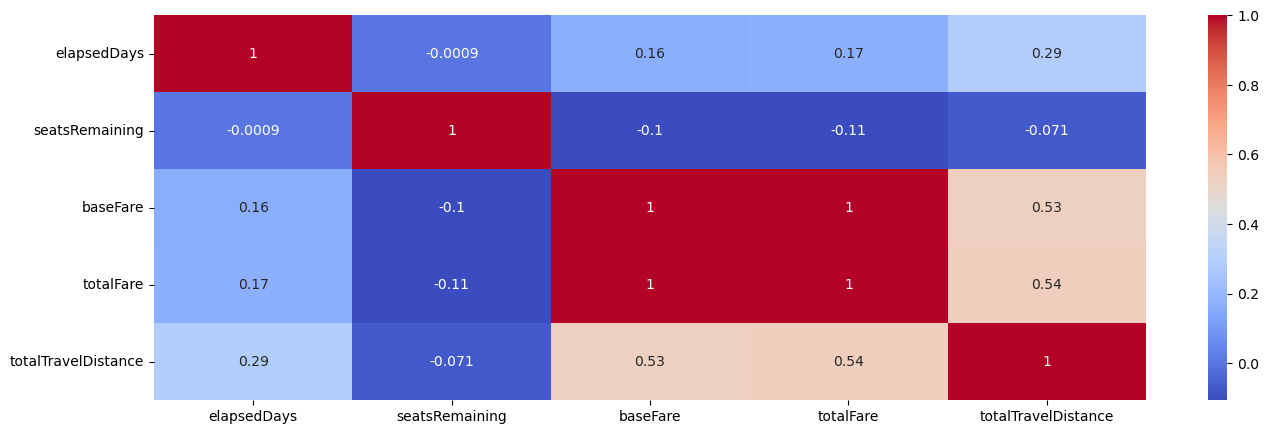

In [78]:
vector_col = 'corr_features'
numeric_columns = numeric_with_zeroes_columns + numeric_without_zeroes_columns

assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
df_vector = assembler.transform(cleaned_df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=numeric_columns, index=numeric_columns) 

plt.figure(figsize=(16,5))  
sns.heatmap(
    corr_matrix_df, 
    xticklabels=corr_matrix_df.columns.values,
    yticklabels=corr_matrix_df.columns.values,  
    cmap= 'coolwarm', 
    annot=True
)

# 2 часть

In [19]:
# Цель - предсказать 'label' на основе входных признаков
data = cleaned_dataframe.select(
    'startingAirport',
    'destinationAirport',
    'elapsedDays',
    col('isBasicEconomy').cast('Int').alias('isBasicEconomy'),
    col('isRefundable').cast('Int').alias('isRefundable'),
    col('isNonStop').cast('Int').alias('isNonStop'),
    'baseFare',
    'totalFare',
    col('totalTravelDistance').alias('label')
)
data.show(10)

+---------------+------------------+-----------+--------------+------------+---------+--------+---------+-----+
|startingAirport|destinationAirport|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|label|
+---------------+------------------+-----------+--------------+------------+---------+--------+---------+-----+
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|  947|
|            ATL|               BOS|          0|             0|           0|        0|  213.02|    251.1

# Линейная регрессия

Процесс построения модели линейной регрессии в PySpark обычно включает в себя следующие шаги:

1. Подготовка данных: Загрузка данных и предварительная обработка, например, преобразование категориальных признаков и масштабирование числовых.

2. Создание столбца признаков: Объединение всех признаков в один вектор.

3. Обучение модели: Создание экземпляра LinearRegression, создание Pipeline с этой моделью и обучение модели на тренировочных данных.

4. Оценка модели: Использование тестовых данных для оценки качества предсказаний модели.

In [21]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer, MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
# Кодирует  столбец строковых меток в столбец индексов меток. 
# применяется для преобразования категориальных переменных в числовой форма
strIdx = StringIndexer(inputCols = ['startingAirport', 'destinationAirport'], outputCols = ['startingAirportIdx', 'destinationAirportIdx'])
# Отображает столбец индексов категорий в столбец бинарных векторов, 
# где только одна единица указывает на присутствие конкретной категории
oneHotEnc = OneHotEncoder(inputCols=['startingAirportIdx', 'destinationAirportIdx'], outputCols=['startingAirportEnc', 'destinationAirportEnc'])
# Отображает заданный список столбцов в один векторный столбец
catVect = VectorAssembler(inputCols = ['startingAirportEnc', 'destinationAirportEnc', 'isBasicEconomy', 'isRefundable', 'isNonStop'], outputCol='catFeatures')
# Объединяет числовые признаки в один вектор
numVect = VectorAssembler(inputCols = ['baseFare', 'totalFare', 'elapsedDays'], outputCol='numFeatures')
# Работает с вектором признаков
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol='normFeatures')
# Объединяет категориальные признаки (catFeatures) и нормализованные числовые признаки (normFeatures) в один вектор признаков
featVect = VectorAssembler(inputCols=['catFeatures', 'normFeatures'], outputCol='features')
# одгоняет линейную регрессионную модель к входным данным
lr = LinearRegression(labelCol='label', featuresCol='features')

pipeline = Pipeline(stages=[strIdx, oneHotEnc, catVect, numVect, minMax, featVect, lr])

# Настройка параметров регрессии

In [20]:
# Разделим данные на обучающую и тестовую выборки
splits = data.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1].withColumnRenamed('label', 'trueLabel')

# Создаем сетку гиперпараметров
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.3, 0.5]) \
    .addGrid(lr.maxIter, [50, 100, 150]).build() 

# Создаем кросс-валидатор
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)
model = crossval.fit(train)

1. Исходные данные data разделяются на обучающую (train) и тестовую (test) выборки в соотношении 80% к 20%. train содержит 80% данных, а test - 20%.
2. Создается сетка гиперпараметров для модели логистической регрессии (lr).
3. Гиперпараметры включают regParam (параметр регуляризации) и maxIter (максимальное количество итераций обучения).
4. Рассматриваются различные комбинации значений для каждого параметра.

# Генерация предсказаний модели регрессии

In [23]:
predictions = model.transform(test)
predictions = predictions.select('features', 'prediction', 'trueLabel')
predictions.show(100, truncate=False)

+---------------------------------------------------------------------------------+------------------+---------+
|features                                                                         |prediction        |trueLabel|
+---------------------------------------------------------------------------------+------------------+---------+
|(36,[8,18,33,34],[1.0,1.0,0.2069934985064137,0.2164258861101681])                |1027.8787254622098|956      |
|(36,[8,18,33,34],[1.0,1.0,0.2069934985064137,0.2164258861101681])                |1027.8787254622098|956      |
|(36,[8,18,33,34],[1.0,1.0,0.2069934985064137,0.2164258861101681])                |1027.8787254622098|956      |
|(36,[8,18,33,34],[1.0,1.0,0.2069934985064137,0.2164258861101681])                |1027.8787254622098|956      |
|(36,[8,18,33,34],[1.0,1.0,0.2069934985064137,0.2164258861101681])                |1027.8787254622098|956      |
|(36,[8,18,33,34],[1.0,1.0,0.2069934985064137,0.2183118956910968])                |1022.95883434

# Оценим качество модели

In [24]:
 evaluator_mse = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="mse")
 mse = evaluator_mse.evaluate(predictions)
 print(f'Metric "MSE" on test data: {mse:.3f}')

 evaluator_mae = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="mae")
 mae = evaluator_mae.evaluate(predictions)
 print(f'Metric "mae" on test data: {mae:.3f}')

 evaluator_rmse = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="rmse")
 rmse = evaluator_rmse.evaluate(predictions)
 print(f'Metric "rmse" on test data: {rmse:.3f}')

 evaluator_r2 = RegressionEvaluator(labelCol='trueLabel', predictionCol='prediction', metricName="r2")
 r2 = evaluator_r2.evaluate(predictions)
 print(f'Metric "R^2" on test data: {r2:.3f}')

Metric "MSE" on test data: 280043.962
Metric "mae" on test data: 398.396
Metric "rmse" on test data: 529.192
Metric "R^2" on test data: 0.595


**Root Mean Squared Error (RMSE)** на тестовых данных составляет 299117.462. 
RMSE измеряет среднеквадратичное отклонение предсказанных значений от фактических значений. 
Чем ближе значение RMSE к нулю, тем лучше. 299117.462 может считаться высоким значением,
и это может свидетельствовать о том, что модель не всегда точно предсказывает целевую переменную.

**Mean Absolute Error (MAE)** на тестовых данных равен 405.624. MAE измеряет среднее абсолютное отклонение предсказанных значений от фактических значений. Как и RMSE, MAE чувствителен к большим отклонениям. Значение 405.624 может служить показателем того, насколько в среднем модель ошибается в предсказании целевой переменной.

**R-squared (R^2** на тестовых данных равен 0.573. R^2 представляет собой коэффициент детерминации и измеряет долю дисперсии зависимой переменной, объясненную моделью. Значение R^2 от 0 до 1, и чем ближе к 1, тем лучше модель объясняет изменение в зависимой переменной. Значение 0.573 говорит о том, что модель объясняет примерно 57.3% дисперсии в данных, что может быть считаться умеренно хорошим результатом.

**MSE (Mean Squared Error)** - это метрика, используемая для оценки качества модели, обученной на регрессии. Эта метрика измеряет среднеквадратичную разность между фактическими и предсказанными значениями: 280043.962.

In [59]:
# Вывод лучших параметров
best_model = model.bestModel
best_parameters = best_model.stages[-1].extractParamMap()
print("Лучшие параметры модели LinearRegression:")
for param, value in best_parameters.items():
    print(f"{param.name}: {value}")

Лучшие параметры модели LinearRegression:
aggregationDepth: 2
elasticNetParam: 0.0
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: label
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 150
predictionCol: prediction
regParam: 0.0
solver: auto
standardization: True
tol: 1e-06


1. aggregationDepth: 2: процесс обучения использует двухуровневую агрегацию.Значение 2 может указывать на то, что используется умеренная сложность
2. elasticNetParam: 0.0: модели используется только L2-регуляризация.
3. epsilon: 1.35: : Параметр регуляризации, который добавляется к функции потерь во время обучения модели.  Значение 1.35 может быть оптимальным для заданной задачи и данных.
4. featuresCol: features: Имя столбца, содержащего признаки."
5. fitIntercept: True: Указывает, что модель должна оценить коэффициент пересечения (intercept).
6. labelCol: label: Имя столбца, содержащего целевую переменную.
7. loss: squaredError: Функция потерь, используемая в модели, является среднеквадратичной ошибкой.
8. maxBlockSizeInMB: 0.0: Это параметр, влияющий на производительность обучения.
9. maxIter: 100: Максимальное количество итераций.,
10. predictionCol: prediction: Имя столбца, содержащего предсказания модели.
11. regParam: 0.0: Этот параметр указывает на отсутствие регуляризации в модели.
12. solver: auto: Метод решения задачи оптимизации при обучении модели выбирается автоматически.
13. sstandardization: True: Указывает, что признаки будут стандартизированы перед обучением модели.
14. Tol: 1e-06: минимальное значение изменения, при котором обучение модели будет становлено.

**Гиперпараметры:**

regParam: Этот гиперпараметр управляет силой регуляризации в модели. Чем больше значение, тем сильнее регуляризация.

elasticNetParam: Этот гиперпараметр управляет смесью между L1 и L2 регуляризацией. Значение 0 соответствует только L2 (Ridge) регуляризации, значение 1 - только L1 (Lasso) регуляризации, а промежуточные значения представляют смесь обеих форм регуляризации.

maxIter: Этот гиперпараметр определяет максимальное количество итераций, используемых для обучения модели.

tol: Параметр остановки, который указывает минимальное изменение, при котором обучение будет остановлено.

fitIntercept: Этот гиперпараметр определяет, следует ли оценивать коэффициент пересечения (intercept).

solver: Этот гиперпараметр определяет метод решения задачи оптимизации при обучении модели.

aggregationDepth: Этот гиперпараметр управляет глубиной агрегации, используемой для распределенного обучения модели.модели.ения модели.

# Gradient Boosting

##  Подготовка данных
1 для рейса, который пролетел более среднего расстояния 1500 миль.  

0 для рейса, который пролетел менее среднего расстояния 1500 миль.

In [6]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

data_class = cleaned_df.select(
    'startingAirport',
    'destinationAirport',
    'elapsedDays',
    col('isBasicEconomy').cast('Int').alias('isBasicEconomy'),
    col('isRefundable').cast('Int').alias('isRefundable'),
    col('isNonStop').cast('Int').alias('isNonStop'),
    'baseFare',
    'totalFare',
    (col('totalTravelDistance') > 1500).cast('Int').alias('label')
)
data_class.show(10)

+---------------+------------------+-----------+--------------+------------+---------+--------+---------+-----+
|startingAirport|destinationAirport|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|label|
+---------------+------------------+-----------+--------------+------------+---------+--------+---------+-----+
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|           0|        1|  217.67|    248.6|    0|
|            ATL|               BOS|          0|             0|           0|        0|  213.02|    251.1

In [9]:
strIdx = StringIndexer(inputCols = ['startingAirport', 'destinationAirport'], outputCols = ['startingAirportIdx', 'destinationAirportIdx'])
oneHotEnc = OneHotEncoder(inputCols=['startingAirportIdx', 'destinationAirportIdx'], outputCols=['startingAirportEnc', 'destinationAirportEnc'])
catVect = VectorAssembler(inputCols=['startingAirportEnc', 'destinationAirportEnc', 'isBasicEconomy', 'isRefundable', 'isNonStop'], outputCol='catFeatures')

numVect = VectorAssembler(inputCols=['baseFare', 'totalFare', 'elapsedDays'], outputCol='numFeatures')
minMax = MinMaxScaler(inputCol=numVect.getOutputCol(), outputCol='normFeatures')

featVect = VectorAssembler(inputCols=['catFeatures', 'normFeatures'], outputCol='features')
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxDepth=4, maxBins=16)

pipeline = Pipeline(stages=[strIdx, oneHotEnc, catVect, numVect, minMax, featVect, gbt])

# Параметры бинарной классификации

In [10]:
splits = data_class.randomSplit([0.8, 0.2])
train = splits[0]
test = splits[1].withColumnRenamed('label', 'trueLabel')

positive_count = train.filter(col("label") == 1).count()
negative_count = train.filter(col("label") == 0).count()
balance_ratio = positive_count / negative_count
print("Positive to Negative Class Ratio:", balance_ratio)

Positive to Negative Class Ratio: 0.8865827570038682


Значение ближе к 1 указывает на относительно сбалансированные классы
Значения, отличные от 1, указывают на дисбаланс классов.

In [14]:
paramGrid = (ParamGridBuilder() \
             .addGrid(gbt.maxDepth, [2, 4, 6]) \
             .addGrid(gbt.maxBins, [8, 16, 32]) \
             .build())

crossval  = CrossValidator(
    estimator=pipeline,
    evaluator=BinaryClassificationEvaluator(),
    estimatorParamMaps=paramGrid,
    numFolds=2
)
model  = crossval.fit(train)

# Предсказания

In [16]:
predictions = model.transform(test)
predictions = predictions.select('features', 'prediction', 'trueLabel')
predictions.show(50, truncate=False)

+----------------------------------------------------------------------------------+----------+---------+
|features                                                                          |prediction|trueLabel|
+----------------------------------------------------------------------------------+----------+---------+
|(36,[8,19,33,34],[1.0,1.0,0.04347554536060231,0.04545730636476233])               |0.0       |0        |
|(36,[8,19,33,34],[1.0,1.0,0.04347554536060231,0.04585343696109733])               |0.0       |0        |
|(36,[8,19,33,34],[1.0,1.0,0.04347554536060231,0.04585343696109733])               |0.0       |0        |
|(36,[8,19,33,34],[1.0,1.0,0.04347554536060231,0.04585343696109733])               |0.0       |0        |
|(36,[8,19,33,34],[1.0,1.0,0.04347554536060231,0.04585343696109733])               |0.0       |0        |
|(36,[8,19,33,34],[1.0,1.0,0.04347554536060231,0.04585343696109733])               |0.0       |0        |
|(36,[8,19,33,34],[1.0,1.0,0.04347554536060231

# Оценка качества модели

In [17]:
evaluator = BinaryClassificationEvaluator(labelCol='trueLabel', rawPredictionCol='rawPrediction', metricName="areaUnderROC")
# Оценка качества модели
area_under_roc_cv = evaluator.evaluate(prediction)
print(f"Area under ROC curve (cross-validated): {area_under_roc_cv}")

# Метрики классификации
true_positives = predictions.filter("prediction = 1.0 AND label = 1").count()
true_negatives = predictions.filter("prediction = 0.0 AND label = 0").count()
false_positives = predictions.filter("prediction = 1.0 AND label = 0").count()
false_negatives = predictions.filter("prediction = 0.0 AND label = 1").count()

# Accuracy (точность)
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
print(f"Accuracy: {accuracy}")

# Precision (точность)
precision = true_positives / (true_positives + false_positives)
print(f"Precision: {precision}")

# Recall (полнота)
recall = true_positives / (true_positives + false_negatives)
print(f"Recall: {recall}")

# F1 Score (F-мера)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score}")

# Вывод матрицы ошибок (Confusion Matrix)
print("\n Confusion Matrix:")
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

best_model = model.bestModel
print("Лучшие параметры модели:")
for param_name, param_value in best_model.stages[-1].extractParamMap().items():
    print(f"{param_name.name}: {param_value}")

Area under ROC curve (cross-validated): 0.9617749248391064
Accuracy: 0.898766083869031
Precision: 0.9164222017040474
Recall: 0.8633751018520558
F1 Score: 0.8891081137777174

 Confusion Matrix:
True Positives: 78410
True Negatives: 95237
False Positives: 7151
False Negatives: 12408
Лучшие параметры модели:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: features
impurity: variance
labelCol: label
leafCol: 
lossType: logistic
maxBins: 8
maxDepth: 6
maxIter: 20
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 8151012960518979904
stepSize: 0.1
subsamplingRate: 1.0
validationTol: 0.01


**Area under ROC curve (AUC-ROC):** Значение 0.9617 говорит о высокой эффективности модели в разделении классов. AUC-ROC является показателем качества классификации, где значение ближе к 1 указывает на лучшую производительность модели.

**Accuracy (Точность):** Значение 0.8988 означает, что модель правильно классифицировала примерно 89.88% всех случаев.

**Precision (Точность):** Значение 0.9164 говорит о том, что из всех примеров, которые модель классифицировала как положительные, около 91.64% действительно принадлежат к положительному классу. Это измеряет точность положительных предсказаний.

**Recall (Полнота):** Значение 0.8634 указывает на то, что модель уловила около 86.34% всех положительных случаев из общего числа положительных случаев. Это измеряет способность модели обнаруживать все положительные примеры.

**F1 Score (F1-мера):** Значение 0.8891 является средним гармоническим между точностью и полнотой. Он предоставляет баланс между двумя метриками.

cacheNodeIds: Булев параметр, указывающий, следует ли кэшировать идентификаторы узлов. Кэширование может улучшить производительность в случае многократного использования узлов.

checkpointInterval: Периодичность (в количество итераций), с которой следует выполнять контрольные точки. Контрольные точки используются для сохранения состояния модели и могут быть полезными при восстановлении после сбоев.

featureSubsetStrategy: Стратегия выбора подмножества признаков для обучения каждого дерева. Значение "all" означает использование всех признаков.

featuresCol: Название столбца, содержащего признаки. В данном случае, "features".

impurity: Критерий для измерения качества разделения в деревьях. В данном случае, "variance" используется для регрессии.

labelCol: Название столбца, содержащего целевую переменную. В данном случае, "label".

leafCol: Название столбца, в который будет записан номер листа, к которому относится предсказание.

lossType: Тип функции потерь для градиентного бустинга. "logistic" означает логистическую функцию потерь, что подходит для бинарной классификации.

maxBins: Максимальное количество бинов, используемых при разделении категориальных признаков.

maxDepth: Максимальная глубина каждого дерева в композиции.

maxIter: Максимальное количество итераций (деревьев) для обучения.

maxMemoryInMB: Максимальный объем памяти в мегабайтах для кэширования узлов.

minInfoGain: Минимальный информационный выигрыш, необходимый для разделения узла.

minInstancesPerNode: Минимальное количество экземпляров, требуемых для образования узла.

minWeightFractionPerNode: Минимальная доля веса, необходимая для образования узла.

predictionCol: Название столбца, в который будет записан результат предсказания.

probabilityCol: Название столбца, в который будут записаны вероятности предсказания классов.

rawPredictionCol: Название столбца, в который будут записаны сырые предсказания перед применением функции потерь.

seed: Зерно для воспроизводимости результатов.

stepSize: Размер шага для обновления весов при градиентном спуске.

subsamplingRate: Доля данных, используемых для обучения каждого дерева.

validationTol: Параметр, определяющий, когда остановить обучение на основе изменения ошибки на валидационных данных.

### Вывод
В ходе лабораторной работы было использовано машинное обучение с помощью PySpark для анализа больших данных. В процессе работы были выполнены следующие задачи:

1. Изучение основных алгоритмов машинного обучения.
2. Изучение возможностей библиотеки Spark ML для реализации машинного обучения.
3. Разработка программного обеспечения для анализа данных с использованием PySpark.ark.